In [1]:
from openai import OpenAI
import json


In [2]:
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

In [3]:
schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "receipt",
        "schema": {
            "type": "object",
                "properties": {
                    "category": {"type": "string"},
                    "date": {"type": "string"},
                    "total": {"type": "integer"},
                },
                "required": ["category", "total"]
                },
            }
        }


In [4]:
from pydantic import BaseModel
class Receipt(BaseModel):
    category: str
    date: str
    total: int

In [5]:
system_prompt = """You are a helpful assistant trained to extract structured information from unstructured text. Your task is to process scanned receipt text and output JSON object with three require pieces of information.

The model you are generating should have three fields:
1. **category**: The spending category which belongs to food, shopping, grocery, medical and misca
2. **date**: The date the receipt was issued in the format "MM/DD/YYYY".
3. **total**: The total amount spent, formatted as a number (e.g., "25", "123.45").

### Instructions:
- Identify the spending category, date, and total amount. 
- If any information is missing, leave the corresponding field blank.
- Ensure the output strictly adheres to the following JSON Schema:
  schema = {
    "type": "object",
    "properties": {
        "category": {"type": "string"},
        "date": {"type": "string"},
        "Total": {"type": "integer"}
    },
    "required": ["category", "amount"]
  }
- Output only the JSON Schema as the example showed
- DO NOT INCLUDE ANY COMMENTATION OR CONVERSATION
- DO NOT INCLUDE "Here is the extracted information in JSON format:..." in output

### Example:
- Input:
Boiling Point
123 Alexander Ave, San Jose, CA 95112
01/12/2024
1. Seafood Hot Pot              $15.99
2. Beef Hot Pot                 $17.99
Subtotal                        $33.98
Tax                             $3.4
Total                           $37.38

- Output:
{
  "category": "Food",
  "date": "01/12/2024",
  "Total": 37.38
}
"""

In [44]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract

def correct_image_orientation(image_path):
    # Open the image file
    img = Image.open(image_path)

    # Check if the image has EXIF data (metadata)
    try:
        # Extract EXIF data
        exif = img._getexif()
        if exif is not None:
            # Find the orientation tag
            for tag, value in exif.items():
                if tag == 274:  # Orientation tag in EXIF
                    # Rotate the image based on the orientation value
                    if value == 3:
                        img = img.rotate(180, expand=True)
                    elif value == 6:
                        img = img.rotate(270, expand=True)
                    elif value == 8:
                        img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # If no EXIF data exists, skip the correction
        pass
    return img

def preprocess_image(image_path):
    dpi = 300
    img = correct_image_orientation(image_path)
    img.info['dpi'] = (dpi, dpi)
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #opt_thr, img_ = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    return gray

OCR 1

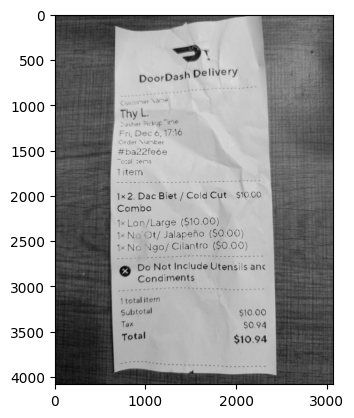

In [45]:
path = r'W:\receipt_ocr\uploads\8a93939e-6da0-4f01-9153-77b976c28d4c3043702456527567075.jpg'
processed_img1 = preprocess_image(path)
plt.imshow(processed_img1, cmap = 'gray')

OG IMAGE

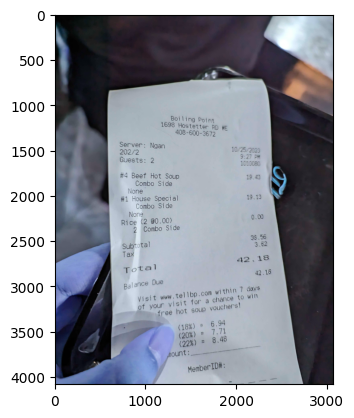

In [49]:
im = cv2.imread('receipt1.jpg')
plt.imshow(im)

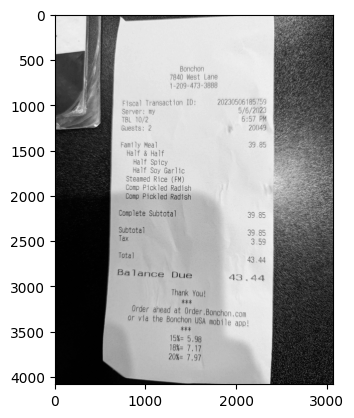

In [ ]:

plt.imshow(preprocess_img,cmap = 'gray')

In [50]:
text = pytesseract.image_to_string(processed_img1, config = '--oem 1 --psm 3')
print(text)

1x2. Dac Biet / Cold Cut $10.00

Cambeo

1x Lon/Large ($10.00)
IxNo Ot/ Jalapeno | ($0.00)
Ix No Ngo/ antro (90.00)

a ae ee ee eee ee ee.

6) Do Not Include Utensils anc
Condiments

yg eat BRE RES erm <a
te ee ee)
5 UN faethe :

AR ee awe ee

{ total item
Subtotal 610.00
Y » $0.94




In [24]:
user_prompt = '''Below is the receipt that you need to extract information from.
{}'''

In [25]:
response = client.beta.chat.completions.parse(
    model="QuantFactory/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct.Q4_0.gguf",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt.format(text)}
    ],
    max_tokens = 50,
    temperature= 0.1,
    response_format= schema
)

In [26]:
results = json.loads(response.choices[0].message.content)
print(json.dumps(results, indent=2))

{
  "category": "Food",
  "date": "12/6/2022",
  "Total": 10.94
}
